Alexander S. Lundervold, v.06.03.24

# Introduction

This notebook provides a hands-on demonstration of how adversarial attacks can mislead deep learning models. Specifically, we'll explore the Fast Gradient Sign Method (FGSM) to generate adversarial examples.

First, we'll train a model for abnormality detection in medical X-rays using the MURA dataset (https://stanfordmlgroup.github.io/competitions/mura/). Then, we'll use FSGM to construct adversarial perturbations and observe how they affect our model's classification accuracy.

> This example is related to a module in the DAT255 course at HVL (https://github.com/HVL-ML/DAT255). For details about the below approach, refer to the notebook [DAT255-3.2-adversarial-dogs-vs-cats.ipynb](https://www.kaggle.com/code/alexanderlundervold/dat255-1-0-adversarial-dogs-vs-cats).

# Setup

In [1]:
from fastai.vision.all import *

In [2]:
# This is a quick check of whether the notebook is currently running on Kaggle, 
import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', False)

In [3]:
kaggle

False

In [4]:
if kaggle:
    DATA = Path('/kaggle/input/mura-v11')
    DATA.ls()
else: 
    NB_DIR = Path.cwd()
    DATA = Path.home()/'data'/'mura-v11'
    DATA.mkdir(exist_ok=True)

# Download and prepare data

In [5]:
if not kaggle: 
    # Download the data set using the Kaggle API 
    # (OBS: you need to provide your own credentials. See https://www.kaggle.com/docs/api)

    if not (DATA/'mura-v11.zip').exists():
        !kaggle datasets download -d cjinny/mura-v11 -p {DATA}
    else:
        print('File already downloaded')
    
    # Unzip the data
    
    # Check if already unzipped
        
    if not (DATA/'MURA-v1.1').exists():
        import shutil
        shutil.unpack_archive(DATA/'mura-v11.zip', DATA)
    else:
        print('Files already unpacked')

File already downloaded
Files already unpacked


In [6]:
# We combine the train and valid dataframes into one, 
# and add a column to indicate whether the image is part of the validation set or not.

train_df = pd.read_csv(DATA/'MURA-v1.1'/'train_image_paths.csv', header=None)
valid_df = pd.read_csv(DATA/'MURA-v1.1'/'valid_image_paths.csv', header=None)

train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df], axis=0)

df.columns = ["study", "is_valid"]

In [7]:
df.head()

,study,is_valid
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,False
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,False
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,False
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,False
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,False


We can grab the labels and other image info from the filenames: 

In [8]:
def get_label(fn):
    return fn.split("/")[-2].split("_")[-1]

def get_subject_id(fn):
    return fn.split("/")[-3][7:]

def get_bodypart(fn):
    return fn.split("/")[2]

...and insert the information into the dataframe:

In [9]:
df['label'] = df["study"].apply(get_label)

In [10]:
df['subject_id'] = df["study"].apply(get_subject_id)

In [11]:
df['bodypart'] = df["study"].apply(get_bodypart)

In [12]:
df.head()

,study,is_valid,label,subject_id,bodypart
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,False,positive,00001,XR_SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,False,positive,00001,XR_SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,False,positive,00001,XR_SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,False,positive,00002,XR_SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,False,positive,00002,XR_SHOULDER


In [13]:
df.label.value_counts()

negative    23602
positive    16403
Name: label, dtype: int64

In [14]:
len(df.subject_id.unique())

11967

> **NB:** There are multiple images taken per study, and the label assigned to an image is based on the _study label_. Since abnormalities aren't necessarily visible in every image of a study, this is actually a _multi-view problem_. We will disregard this here and pretend that we have image-level labels, but if you want to achieve a better score, you should take this into account.

## Grab a sample data set

As the below training takes a long time, we'll restrict ourselves to only one class of images

In [15]:
df.bodypart.value_counts()

XR_WRIST       10411
XR_SHOULDER     8942
XR_HAND         6003
XR_FINGER       5567
XR_ELBOW        5396
XR_FOREARM      2126
XR_HUMERUS      1560
Name: bodypart, dtype: int64

In [16]:
bodypart = 'XR_WRIST'

In [17]:
df = df.loc[df.bodypart == bodypart]

In [18]:
df.is_valid.value_counts()

False    9752
True      659
Name: is_valid, dtype: int64

In [19]:
df.label.value_counts()

negative    6129
positive    4282
Name: label, dtype: int64

# Dataloaders

Now, we set up fastai dataloaders for the training and validation sets.

In [20]:
sz=224
item_tfms = Resize(sz)
batch_tfms = None
bs=64

In [21]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_x=ColReader('study', pref=DATA), 
                   get_y=ColReader('label'),
                   splitter=ColSplitter(col='is_valid'), 
                   item_tfms=item_tfms, 
                   batch_tfms=batch_tfms)


In [22]:
dls = dblock.dataloaders(df, path=DATA, bs=bs)

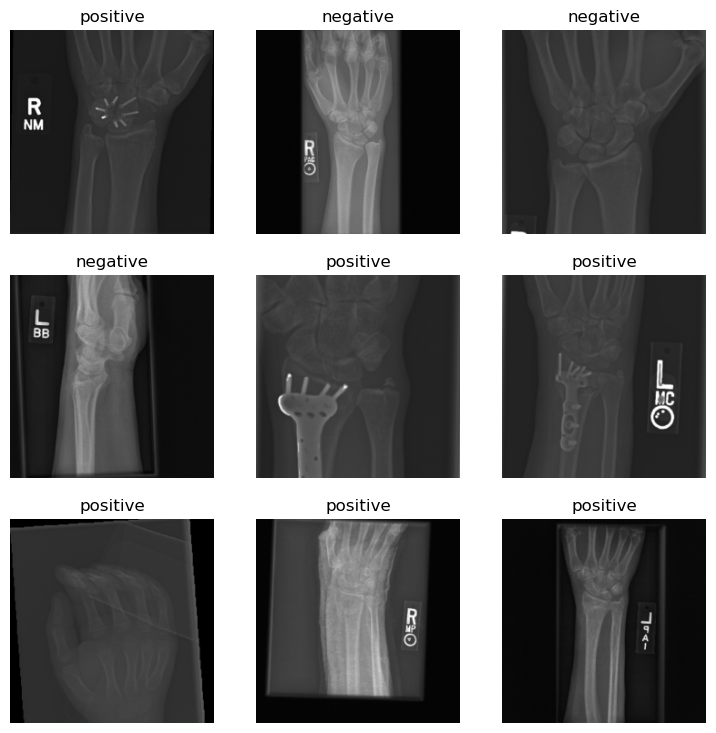

In [23]:
dls.show_batch()

# Train a model

Now we have to choose a model. We use a pretrained model from the [PyTorch Image Models](https://timm.fast.ai/) library.

In [52]:
import timm

In [53]:
#timm.list_models("*convnext*")

In [54]:
model = 'convnext_tiny_in22ft1k'

In [55]:
if kaggle:
    model_dir = Path("/kaggle/working/models")
else: 
    model_dir = DATA/'models'

In [56]:
learn = vision_learner(dls, model, metrics=accuracy, model_dir=model_dir)

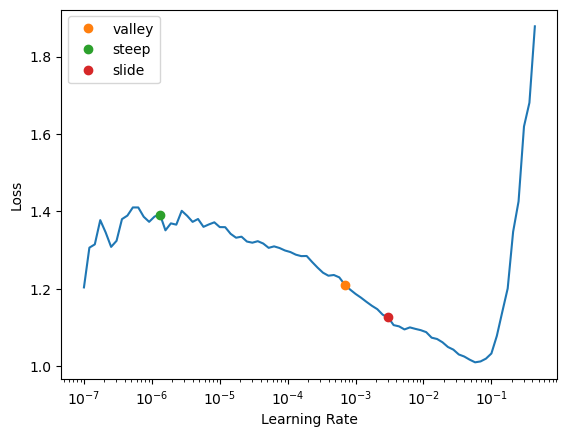

In [57]:
lr = learn.lr_find(suggest_funcs=(valley, steep, slide))

In [59]:
base_lr = (lr.valley + lr.slide)/2
print(base_lr)

0.0018558913725428283


In [60]:
# You can train for fewer epoch if you want to speed up the training
learn.fine_tune(5, base_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.656606,0.516934,0.795144,00:22


epoch,train_loss,valid_loss,accuracy,time
0,0.469899,0.422849,0.828528,01:17
1,0.423836,0.385645,0.830046,01:17
2,0.378982,0.381254,0.836115,01:18
3,0.342520,0.377656,0.839150,01:17
4,0.308041,0.374267,0.839150,01:17


# Evaluate model

In [61]:
interp = ClassificationInterpretation.from_learner(learn)

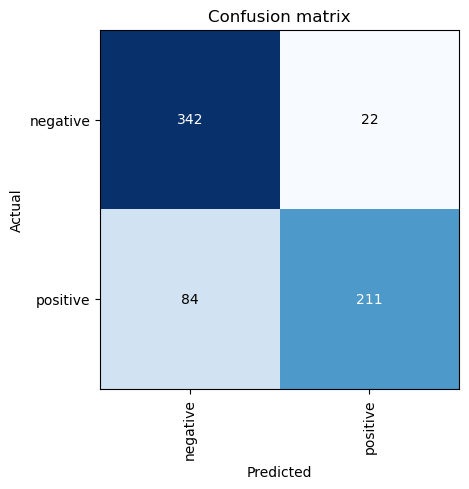

In [62]:
interp.plot_confusion_matrix()

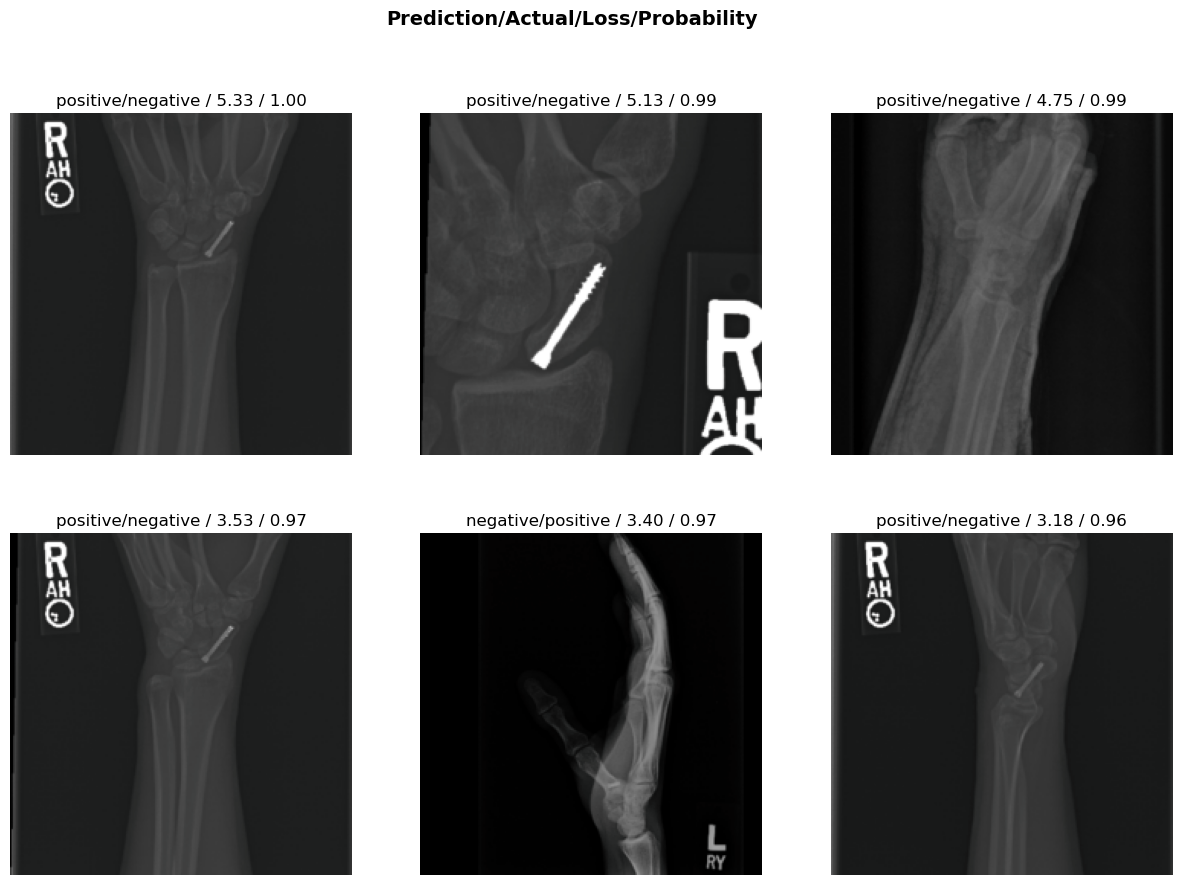

In [65]:
interp.plot_top_losses(6, figsize=(15,10))

In [64]:
interp.print_classification_report()

              precision    recall  f1-score   support

    negative       0.80      0.94      0.87       364
    positive       0.91      0.72      0.80       295

    accuracy                           0.84       659
   macro avg       0.85      0.83      0.83       659
weighted avg       0.85      0.84      0.84       659



# Export the model

In [66]:
learn.export(model_dir/f'mura_model-{model}.pkl')

# FGSM attack

> See the notebook [DAT255-3.2-adversarial-dogs-vs-cats.ipynb](https://www.kaggle.com/code/alexanderlundervold/dat255-1-0-adversarial-dogs-vs-cats) for more details.

In [67]:
learn = load_learner(model_dir/f'mura_model-{model}.pkl')

In [68]:
learn.training

False

In [69]:
df.loc[df.is_valid==True].head()

,study,is_valid,label,subject_id,bodypart
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,True,positive,11185,XR_WRIST
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,True,positive,11185,XR_WRIST
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,True,positive,11185,XR_WRIST
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,True,positive,11185,XR_WRIST
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,True,positive,11186,XR_WRIST


In [70]:
import torchvision.transforms as T

In [71]:
def fgsm_attack(image, epsilon, image_grad):
    """
    Perform the Fast Gradient Sign Method (FGSM) attack on an image.

    Parameters:
    image: The original image.
    epsilon: The epsilon value used to perturb the image.
    image_grad: The gradients of the image.

    Returns:
    perturbed_image: The perturbed image.
    """
    
    # Collect the element-wise sign of the image gradient
    sign_image_grad = image_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_image_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [72]:
def perturb(learn, img_path, epsilon):
    """
    Perform an adversarial attack on an image and return the perturbed image and the predicted labels.

    Parameters:
    learn: The Learner object.
    img_path: The path to the image to be perturbed.
    epsilon: The epsilon value used to perturb the image.

    Returns:
    perturbed_image: The perturbed image.
    predicted_label: The label predicted for the original image.
    perturbed_label: The label predicted for the perturbed image.
    """

    # Perform the transformations and instruct PyTorch to track the gradients
    img_t = T.ToTensor()(PILImage.create(img_path).resize((sz,sz)))
    img_t = img_t.requires_grad_(True)

    output = learn.model(img_t[None])

    # Here's the prediction before the attack
    predicted_label = torch.argmax(output)

    # Perform the attack
    loss = learn.loss_func(output, predicted_label)
    learn.zero_grad()
    loss.backward()
    img_t_grad = img_t.grad.data
    perturbed_image = fgsm_attack(img_t, epsilon, img_t_grad)

    # Here's the prediction after the attack
    perturbed_output = learn.model(perturbed_image[None])
    perturbed_label = torch.argmax(perturbed_output)

    # We need to convert the image back to numpy for plotting
    perturbed_image = perturbed_image.detach().cpu().permute(1, 2, 0).numpy()

    return perturbed_image, learn.dls.vocab[predicted_label], learn.dls.vocab[perturbed_label]

In [73]:
def show_perturbed_img(original_image, predicted_label, perturbed_image, perturbed_label, epsilon):
    """
    Display an original image and its perturbed version side by side.

    Parameters:
    original_image: The original image.
    predicted_label: The label predicted for the original image.
    perturbed_image: The perturbed image.
    perturbed_label: The label predicted for the perturbed image.
    epsilon: The epsilon value used to perturb the image.
    """
    
    f, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(PILImage.create(original_image).resize((sz,sz)))
    ax[0].axis('off')
    ax[0].set_title(f"Original image. Label: {predicted_label}")

    ax[1].imshow(perturbed_image)
    ax[1].axis('off')
    ax[1].set_title(f"Perturbed image. Label: {perturbed_label}; Epsilon: {epsilon}")

    plt.show()

In [74]:
epsilon=0.002

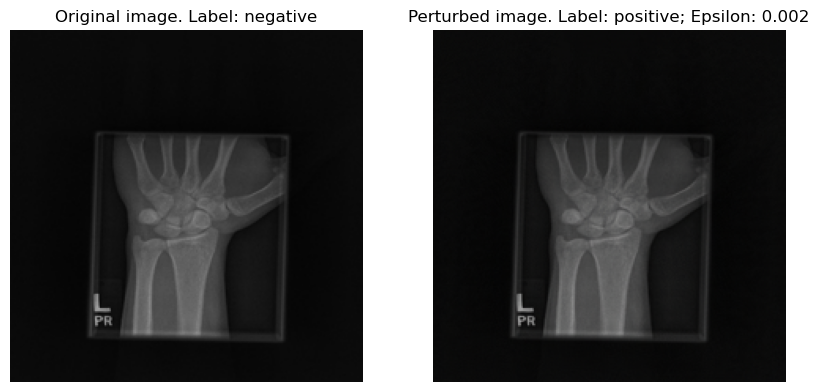

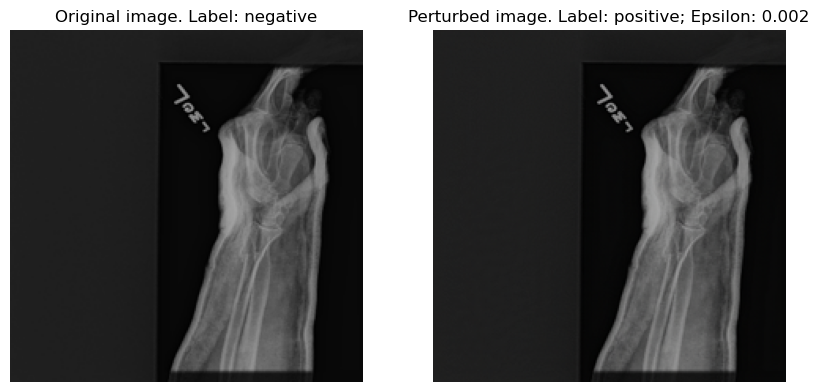

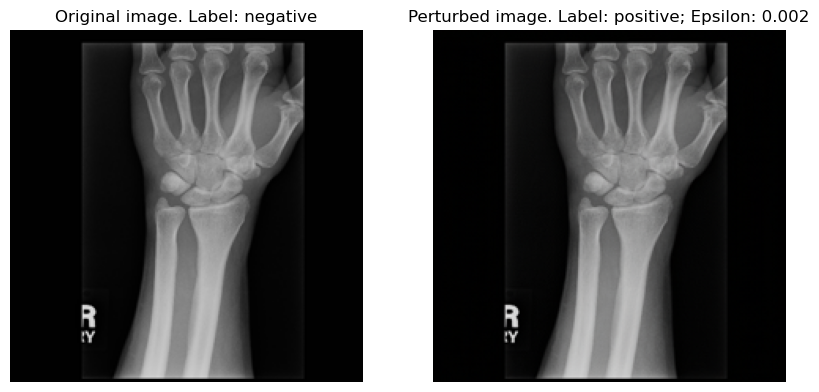

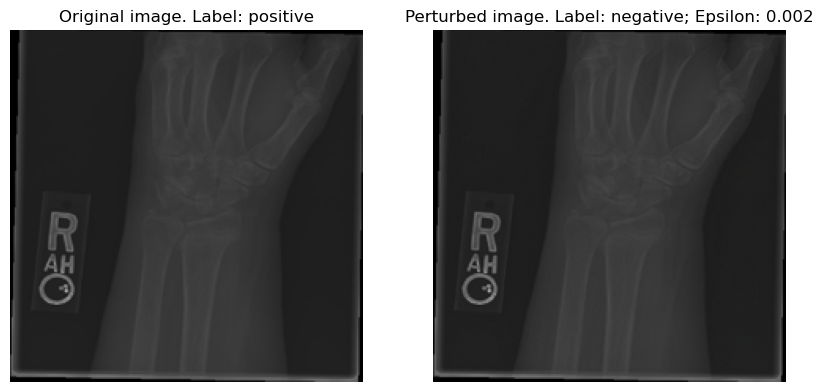

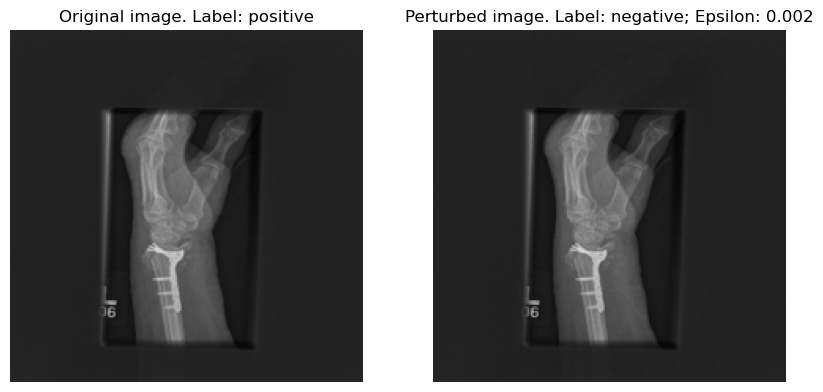

In [75]:
for test_img in random.choices(df.loc[df.is_valid==True].study, k=5):
    test_img = DATA/test_img
    perturbed_image, predicted_label, perturbed_label = perturb(learn, test_img, epsilon)
    show_perturbed_img(test_img, predicted_label, perturbed_image, perturbed_label, epsilon=epsilon)